In [1]:
# 切換工作目錄
import os
def change_working_directory(path):
    os.chdir(path)
    print("Changed Working Directory to:", os.getcwd())

change_working_directory(r"c:\\Users\\Cark C3 PVT\\Desktop\\DL\\comp2\\DataAugmentationForObjectDetection")


Changed Working Directory to: c:\Users\Cark C3 PVT\Desktop\DL\comp2\DataAugmentationForObjectDetection


In [2]:
import shutil

# 清空資料夾
def clear_folder(folder_path):
    if os.path.exists(folder_path):
        shutil.rmtree(folder_path)
    os.makedirs(folder_path)
clear_folder('./augmented_unbalance_images/')

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pickle as pkl
import tensorflow as tf
from data_aug.data_aug import *
from data_aug.bbox_util import *
import random

random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)




In [4]:
# 加載樣本圖片
def load_sample_image(image_path, annotation_path):
    img = cv2.imread(image_path)[:,:,::-1]  # opencv 加載圖片為 bgr，這裡轉換為 rgb
    bboxes = pkl.load(open(annotation_path, "rb"))
    return img, bboxes

img, bboxes = load_sample_image("messi.jpg", "messi_ann.pkl")

[[ 53.         68.0000175 405.        478.9998225   0.       ]
 [202.         20.99992   496.        486.99978     0.       ]
 [589.         77.0001275 737.        335.9999825   0.       ]
 [723.        327.000125  793.        396.000295    1.       ]]


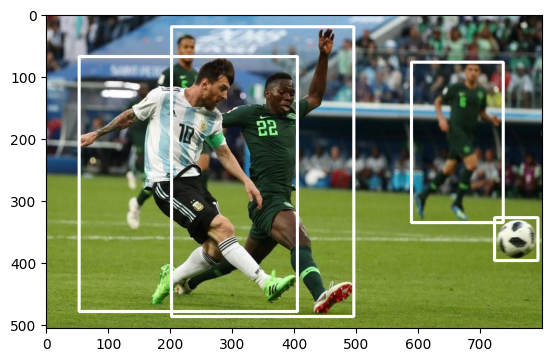

In [5]:
# 檢查 bounding boxes
def inspect_bounding_boxes(img, bboxes):
    print(bboxes)
    plotted_img = draw_rect(img, bboxes)
    plt.imshow(plotted_img)
    plt.show()

inspect_bounding_boxes(img, bboxes)

In [6]:
# 加載訓練數據集
def load_training_data(file_path):
    classes_name = ["aeroplane", "bicycle", "bird", "boat", "bottle",
                    "bus", "car", "cat", "chair", "cow",
                    "diningtable", "dog", "horse", "motorbike", "person",
                    "pottedplant", "sheep", "sofa", "train", "tvmonitor"]
    class_lib = {}
    bbox_lib = {}
    augmented_time = {}
    image_name_list = []
    object_num_list = []
    object_class_list = []

    with open(file_path) as f:
        train_dataset_bboxes = f.readlines()
        for line in train_dataset_bboxes:
            line = line.strip().split()
            img_name = line[0]
            tmp_ls = []
            local_object_class_list = []
            bbox = line[1:]
            image_name_list.append(img_name)
            object_num_list.append(len(bbox)//5)
            for i in range(len(bbox)//5):
                bbox[i*5:i*5+5] = [float(x) for x in bbox[i*5:i*5+5]]
                tmp_ls.append(bbox[i*5:i*5+5])
                class_type = int(bbox[i*5+4])
                local_object_class_list.append(class_type)
                class_name = classes_name[class_type]
                if class_name not in class_lib:
                    class_lib[class_name] = 1
                else:
                    class_lib[class_name] += 1
            tmp_ls = np.array(tmp_ls)
            bbox_lib[img_name] = tmp_ls
            object_class_list.append(local_object_class_list)
            augmented_time[img_name] = 1

    return class_lib, bbox_lib, augmented_time, image_name_list, object_num_list, object_class_list

train_dataset_bboxes_path = '../2024-datalab-cup2-object-detection/pascal_voc_training_data.txt'
class_lib, bbox_lib, augmented_time, image_name_list, object_num_list, object_class_list = load_training_data(train_dataset_bboxes_path)


In [7]:
# 分析類別分佈
classes_name = ["aeroplane", "bicycle", "bird", "boat", "bottle",
                    "bus", "car", "cat", "chair", "cow",
                    "diningtable", "dog", "horse", "motorbike", "person",
                    "pottedplant", "sheep", "sofa", "train", "tvmonitor"]
def analyze_distribution(class_lib, classes_name):
    class_count = np.zeros(20, int)
    for row in range(5):
        for col in range(4):
            index = row*4+col
            class_count[index] = class_lib[classes_name[index]]
            class_name = classes_name[index]
            print(f'{index: 4d}) {class_name:12s} {class_lib[class_name]:8d} {class_count[index]:5d}', end='<|')
        print()

analyze_distribution(class_lib, classes_name)

   0) aeroplane         331   331<|   1) bicycle           417   417<|   2) bird              599   599<|   3) boat              398   398<|
   4) bottle            629   629<|   5) bus               272   272<|   6) car              1636  1636<|   7) cat               389   389<|
   8) chair            1425  1425<|   9) cow               356   356<|  10) diningtable       309   309<|  11) dog               536   536<|
  12) horse             403   403<|  13) motorbike         390   390<|  14) person           5392  5392<|  15) pottedplant       620   620<|
  16) sheep             353   353<|  17) sofa              419   419<|  18) train             328   328<|  19) tvmonitor         366   366<|


In [8]:
# 計算增強次數
def calculate_augmented_times(class_lib, object_num_list, object_class_list, image_name_list, lower_bound=3000):
    rep_class_lib = class_lib.copy()
    descend_object_num_index = np.argsort(object_num_list)[::-1]
    invalid_ele = np.zeros(len(object_num_list), int)
    class_count = np.zeros(20, int)

    while True:
        for i in descend_object_num_index:
            local_object_class_list = object_class_list[i]
            if invalid_ele[i] or (class_count[local_object_class_list] >= lower_bound).any():
                invalid_ele[i] = 1
                continue
            else:
                augmented_time[image_name_list[i]] += 1
                for c in local_object_class_list:
                    class_count[c] += 1
        if (class_count >= lower_bound).all():
            break
    return class_count

class_count = calculate_augmented_times(class_lib, object_num_list, object_class_list, image_name_list)


In [9]:
# 輸出增強次數統計
def output_augmented_times(augmented_time, class_lib, class_count, classes_name):
    augmented_time_sum = sum(augmented_time.values())
    original_time_sum = sum(class_lib.values())
    max_augmented_time = max(augmented_time.values())
    max_augmented_time_img_name = max(augmented_time, key=augmented_time.get)

    print(f'augmented time sum: {augmented_time_sum}')
    print(f'original time sum: {original_time_sum}')
    print(f'max augmented time: {max_augmented_time}')

    for row in range(5):
        for col in range(4):
            index = row*4+col
            class_name = classes_name[index]
            print(f'{index: 4d}) {class_name:12s} orig.: {class_lib[class_name]:8d} aug.: {class_count[index]:5d}', end='<|')
        print()

output_augmented_times(augmented_time, class_lib, class_count, classes_name)

augmented time sum: 37181
original time sum: 15568
max augmented time: 411
   0) aeroplane    orig.:      331 aug.:  3001<|   1) bicycle      orig.:      417 aug.:  3000<|   2) bird         orig.:      599 aug.:  3000<|   3) boat         orig.:      398 aug.:  3006<|
   4) bottle       orig.:      629 aug.:  3002<|   5) bus          orig.:      272 aug.:  3000<|   6) car          orig.:     1636 aug.:  3000<|   7) cat          orig.:      389 aug.:  3000<|
   8) chair        orig.:     1425 aug.:  3000<|   9) cow          orig.:      356 aug.:  3000<|  10) diningtable  orig.:      309 aug.:  3000<|  11) dog          orig.:      536 aug.:  3000<|
  12) horse        orig.:      403 aug.:  3000<|  13) motorbike    orig.:      390 aug.:  3000<|  14) person       orig.:     5392 aug.:  3002<|  15) pottedplant  orig.:      620 aug.:  3018<|
  16) sheep        orig.:      353 aug.:  3006<|  17) sofa         orig.:      419 aug.:  3001<|  18) train        orig.:      328 aug.:  3000<|  19) tvm

In [10]:
# 設置隨機種子
def set_random_seed(seed):
    np.random.seed(seed)
    tf.random.set_seed(seed)

# set_random_seed(42)

[[ 81. 279. 207. 356.   1.]]


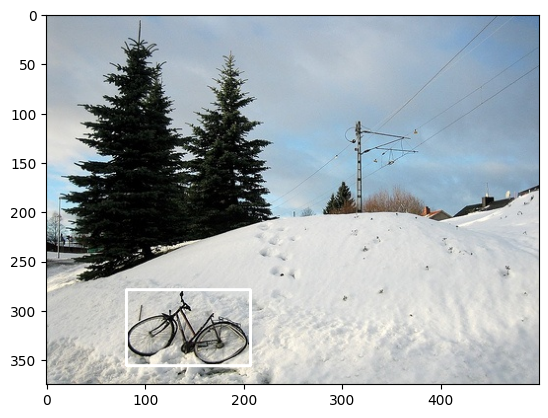

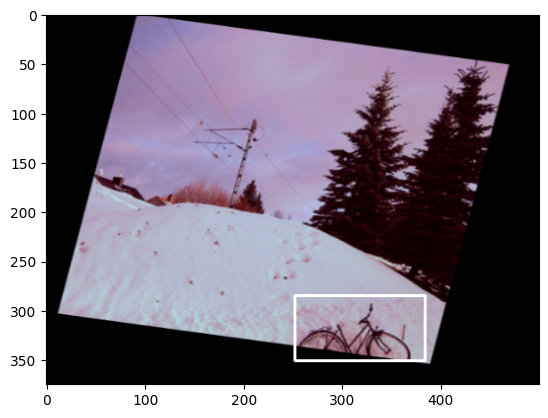

In [11]:
# 檢查單張圖片結果
def check_single_image_result(image_name, bbox_lib, train_dataset_folder):
    img = cv2.imread(train_dataset_folder + image_name)[:,:,::-1]  # opencv 加載圖片為 bgr，這裡轉換為 rgb
    bboxes = bbox_lib[image_name]
    print(bboxes)
    plotted_img = draw_rect(img, bboxes)
    plt.imshow(plotted_img)
    plt.show()

    seq = Sequence([RandomHSV(40, 40, 30), RandomHorizontalFlip(), RandomScale(), RandomTranslate(), RandomRotate(10), RandomShear()])
    img_, bboxes_ = seq(img.copy(), bboxes.copy())
    plotted_img = draw_rect(img_, bboxes_)
    plt.imshow(plotted_img)
    plt.show()

check_single_image_result('001184.jpg', bbox_lib, '../2024-datalab-cup2-object-detection/VOCdevkit_train/VOC2007/JPEGImages/')


In [12]:
# 創建目標文件夾並複製bbox_lib到new_bbox_lib
def create_dst_folder_and_copy_bbox_lib(train_dataset_folder, dst_folder, bbox_lib):
    if not os.path.exists(dst_folder):
        os.makedirs(dst_folder)

    train_dataset_images = os.listdir(train_dataset_folder)
    new_bbox_lib = bbox_lib.copy()
    return train_dataset_images, new_bbox_lib

train_dataset_images, new_bbox_lib = create_dst_folder_and_copy_bbox_lib('../2024-datalab-cup2-object-detection/VOCdevkit_train/VOC2007/JPEGImages/', './augmented_unbalance_images/', bbox_lib)


In [13]:
# # 應用增強
# def apply_augmentation(train_dataset_images, bbox_lib, augmented_time, dst_folder, train_dataset_folder):
#     for image in train_dataset_images:
#         img = tf.io.read_file(train_dataset_folder + image)
#         img = tf.image.decode_jpeg(img, channels=3)
#         if image not in bbox_lib:
#             continue
#         bboxes = bbox_lib[image]
#         repeated_times = augmented_time[image]
#         img_ = tf.image.encode_jpeg(img)
#         tf.io.write_file(dst_folder+image, img_)
#         repeated_times -= 1

#         for i in range(0, repeated_times):
#             tmp = img.numpy().copy()
#             noise = np.random.normal(0, 10, tmp.shape).astype(np.uint8)
#             tmp = tmp + noise
#             deg = i % 180
#             seq = Sequence([RandomHSV(30, 40, 50), RandomHorizontalFlip(0.7), RandomScale(0.1), RandomShear(0.15), RandomRotate(deg)])
#             img_, bboxes_ = seq(tmp, bboxes.copy())
#             if len(bboxes_) == 0:
#                 continue
#             new_name = 'aug_'+ str(i) + '_' + image
#             img_[img_ < 0] = 0
#             bboxes_[bboxes_ < 0] = 0
#             img_[img_ > 255] = 255
#             img_ = tf.image.encode_jpeg(img_)
#             tf.io.write_file(dst_folder+new_name, img_)
#             new_bbox_lib[new_name] = bboxes_

#     for key, value in new_bbox_lib.items():
#         value = value.astype(int)
#         new_bbox_lib[key] = value

# apply_augmentation(train_dataset_images, bbox_lib, augmented_time, './augmented_unbalance_images/', '../2024-datalab-cup2-object-detection/VOCdevkit_train/VOC2007/JPEGImages/')


In [ ]:
# 應用增強（僅處理部分數據以進行測試）
def apply_augmentation(train_dataset_images, bbox_lib, augmented_time, dst_folder, train_dataset_folder, num_samples=10):
    # 隨機選擇部分數據進行處理
    sample_images = np.random.choice(train_dataset_images, num_samples, replace=False)
    
    for image in sample_images:
        img = tf.io.read_file(train_dataset_folder + image)
        img = tf.image.decode_jpeg(img, channels=3)
        if image not in bbox_lib:
            continue
        bboxes = bbox_lib[image]
        repeated_times = augmented_time[image]
        img_ = tf.image.encode_jpeg(img)
        tf.io.write_file(dst_folder+image, img_)
        repeated_times -= 1

        for i in range(0, repeated_times):
            tmp = img.numpy().copy()
            noise = np.random.normal(0, 10, tmp.shape).astype(np.uint8)
            tmp = tmp + noise
            deg = i % 180
            seq = Sequence([RandomHSV(30, 40, 50), RandomHorizontalFlip(0.7), RandomScale(0.1), RandomShear(0.15), RandomRotate(deg)])
            img_, bboxes_ = seq(tmp, bboxes.copy())
            if len(bboxes_) == 0:
                continue
            new_name = 'aug_'+ str(i) + '_' + image
            img_[img_ < 0] = 0
            bboxes_[bboxes_ < 0] = 0
            img_[img_ > 255] = 255
            img_ = tf.image.encode_jpeg(img_)
            tf.io.write_file(dst_folder+new_name, img_)
            new_bbox_lib[new_name] = bboxes_

    for key, value in new_bbox_lib.items():
        value = value.astype(int)
        new_bbox_lib[key] = value

# 測試應用增強函數
apply_augmentation(train_dataset_images, bbox_lib, augmented_time, './augmented_unbalance_images/', '../2024-datalab-cup2-object-detection/VOCdevkit_train/VOC2007/JPEGImages/', num_samples=10)

In [15]:
# 將new_bbox_lib寫入txt文件
def write_new_bbox_lib_to_txt(new_bbox_lib, file_path):
    with open(file_path, 'w') as f:
        for key, value in new_bbox_lib.items():
            f.write(key)
            f.write(' ')
            for bbox in value:
                for element in bbox:
                    f.write(str(element))
                    f.write(' ')
            f.write('\n')

write_new_bbox_lib_to_txt(new_bbox_lib, './augmented_unbalance_images.txt')

In [16]:
# 驗證augmented_unbalance_images.txt和圖片
def verify_augmented_images(file_path, folder_path):
    test_bbox_lib = {}
    with open(file_path) as f:
        buffer = f.readlines()
        for line in buffer:
            line = line.strip().split()
            image_name = line[0]
            tmp_ls = []
            bbox = line[1:]
            for i in range(len(bbox)//5):
                bbox[i*5:i*5+5] = [float(x) for x in bbox[i*5:i*5+5]]
                tmp_ls.append(bbox[i*5:i*5+5])
            tmp_ls = np.array(tmp_ls)
            test_bbox_lib[image_name] = tmp_ls

    return test_bbox_lib

test_bbox_lib = verify_augmented_images('./augmented_unbalance_images.txt', './augmented_unbalance_images/')


006436.jpg
[170.  36. 376. 282.   3.] boat


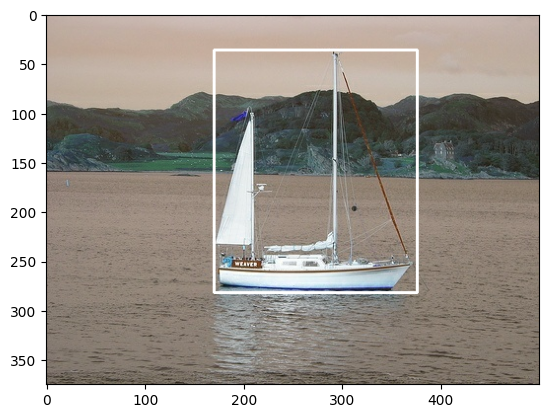

aug_2_006436.jpg
[131.  40. 357. 303.   3.] boat


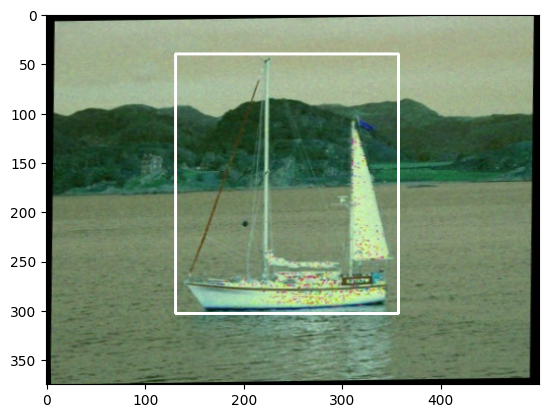

In [17]:
# 比較單張圖片結果
def compare_single_image_result(image_name, test_bbox_lib, folder_path):
    img = cv2.imread(folder_path + image_name)[:,:,::-1]  # opencv 加載圖片為 bgr，這裡轉換為 rgb
    bboxes = test_bbox_lib[image_name]
    print(image_name)
    for bbox in bboxes:
        print(bbox, classes_name[int(bbox[4])])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plotted_img = draw_rect(img, bboxes)
    plt.imshow(plotted_img)
    plt.show()

compare_single_image_result('006436.jpg', test_bbox_lib, './augmented_unbalance_images/')
compare_single_image_result('aug_2_006436.jpg', test_bbox_lib, './augmented_unbalance_images/')